A notebook to create the submission(s).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase, Regression, Stacked, call_variants_from_regression

## Load data

Read the training data with added conservation information.

In [2]:
training = pd.read_csv('data/cagi5_df.csv')
training.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Read the submission template

In [3]:
submission = pd.read_csv(
    'data/5_saturation_mutagenesis_SubmissionTemplate_01.txt',
    sep='\t',
    na_values='*')
submission.sample(6)

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,Direction,P_Direction,Confidence,SE,Comments
10278,11,5271135,C,A,HBG1,NaN,NaN,NaN,NaN,NaN
3307,1,209989309,G,C,IRF6,NaN,NaN,NaN,NaN,NaN
9532,10,51549253,C,G,MSMB,NaN,NaN,NaN,NaN,NaN
12252,22,19710856,G,A,GP1BB,NaN,NaN,NaN,NaN,NaN
10595,11,5271256,A,T,HBG1,NaN,NaN,NaN,NaN,NaN
10225,11,5271117,T,C,HBG1,NaN,NaN,NaN,NaN,NaN


Identify all the submission regions to check they match those in the training data.

In [4]:
sub_regions = submission['Promoter_Enhancer'].unique()
sub_regions.sort()
print(sub_regions)
train_regions = training['regulatory_element'].str.slice(start=8).unique()
train_regions.sort()
print(train_regions)

['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB' 'MYC'
 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']
['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB'
 'MYCrs6983267' 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']


TODO: Make sure that MYC region names match between training and submission data frames.

### Use tuned hyperparameters

These are taken from a kaggle kernel notebook

In [5]:
tuned_params={
    'max_depth': 2, #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': 0.6, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': 0.5, #[0.5,0.6,0.7,0.8],
    'n_estimators': 1000, #[1000,2000,3000]
    'reg_alpha': 0.03 #[0.01, 0.02, 0.03, 0.04]
}

These are tuned by Bayesian optimisation (in another notebook)

In [6]:
tuned_params = {
    'colsample_bytree': 0.7524052235178577,
    'learning_rate': 0.39783003619093765,
    'max_depth': 7,
    'min_child_weight': 4.0467095559059505,
    'reg_alpha': 0.030682622499703896,
    'reg_lambda': 0.40505823486422077,
    'subsample': 1.0
}

### Choose features

In [7]:
def make_features(test):
    deepseadiffs = DeepSeaSNP(feattypes=['diff'], test=test)
    dnase = DNase(test=test)
    # subst = SubstitutionOneHot(test=test)
    # enhancer1hot = EnhancerOneHot(test=test)
    # snpcontext2 = SNPContext(context_size=2, test=test)
    # snpcontext4 = SNPContext(context_size=4, test=test)
    # conservation = Conservation(test=test)
    # stacked = Stacked('deep-dnase-cons', test=test)
    return MultiFeatures([deepseadiffs, dnase])
train_features = make_features(False)
test_features = make_features(True)

## Fit model

In [8]:
model = Regression(train_features)
X_train = model.get_features(training)
y_train = model.get_response(training)
model.fit(X_train, y_train)

## Make predictions

In [9]:
X_test = test_features.get_features(submission)
predictions = model.predict(X_test, submission.index)
predictions.sample(6)

,PredConfidence,PredValue
3561,0.101159,-0.053847
13628,0.133166,-0.150173
12089,0.049097,-0.004931
6164,0.140703,-0.092526
5001,0.460638,-0.762893
2835,0.041942,-0.002757


Call which variants are present from the regression predictions

In [60]:
import models, importlib
importlib.reload(models)
from models import call_variants_from_regression
predictions = call_variants_from_regression(predictions)
predictions.sample(6)

,PredConfidence,PredValue,Direction,ValueRank,P_Direction,Confidence,SE
2815,0.123040,0.049406,0,7871.5,0.476885,0.123040,0.1
12655,0.032689,-0.133688,-1,10597.0,0.458494,0.032689,0.1
12683,0.026262,-0.032574,0,6379.0,0.576085,0.026262,0.1
2904,0.060189,0.013466,0,3067.0,0.796218,0.060189,0.1
5305,0.054395,-0.026703,0,5483.5,0.635604,0.054395,0.1
8604,0.040500,-0.020671,0,4503.5,0.700740,0.040500,0.1


Plot the predicted values against the probability that they are correct coloured by called direction.

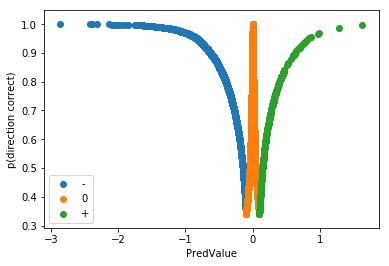

In [61]:
fig, ax = plt.subplots()
neg = -1 == predictions['Direction']
zero = 0 == predictions['Direction']
pos =  1 == predictions['Direction']
ax.scatter(predictions.loc[neg, 'PredValue'], predictions.loc[neg, 'P_Direction'], label='-')
ax.scatter(predictions.loc[zero, 'PredValue'], predictions.loc[zero, 'P_Direction'], label='0')
ax.scatter(predictions.loc[pos, 'PredValue'], predictions.loc[pos, 'P_Direction'], label='+')
ax.legend()
ax.set_xlabel('PredValue')
ax.set_ylabel('p(direction correct)')
None

### Save predictions

In [ ]:
submission.to_csv('data/submission.tsv', sep='\t')